# Changelog

## V38 - Update to mixed precision float16 training, TF 2.4
https://www.kaggle.com/devang/transfer-learning-with-keras-and-efficientnets

## V37 - Updates, switch to EfficientNets, TF 2.3
https://www.kaggle.com/devang/transfer-learning-with-keras-and-efficientnets?scriptVersionId=40698248

## V36 - Updates, works with TF 2.0
https://www.kaggle.com/devang/transfer-learning-with-keras-and-mobilenet-v2?scriptVersionId=24113974

## V32 - Updates, added Confusion Matrix/Classification Report
https://www.kaggle.com/devang/transfer-learning-with-keras-and-mobilenet-v2?scriptVersionId=19440127

## V24 - First working notebook
https://www.kaggle.com/devang/transfer-learning-with-keras-and-mobilenet-v2?scriptVersionId=16125907


# Imports

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
#os.environ["AUTOGRAPH_VERBOSITY"] = "10"
#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import experimental as mixed_precision
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

print("py", python_version())
print("tf", tf.__version__)
print("keras", tf.keras.__version__)
mem = psutil.virtual_memory()
print("mem", mem.total/1024/1024)
cpu = mp.cpu_count()
print("cpu", cpu)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

%system nvidia-smi
#%system rocm-smi

py 3.7.9
tf 2.4.0
keras 2.4.0
mem 16017.58984375
cpu 2
Compute dtype: float16
Variable dtype: float32


['Fri Jan 29 00:28:05 2021       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|                               |                      |               MIG M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   35C    P0    33W / 250W |  15327MiB / 16280MiB |      0%      Default |',
 '|                               |                      |                  N/A |',
 '+-------------------------------+----------------------+----------------------+',
 '                                      

# Variables

In [2]:
epochs = 100
batch_size = 100
testsplit = .2
targetx = 224
targety = 224
learning_rate = 0.0001
classes = 120
seed = random.randint(1, 1000)

data_dir = "/kaggle/input/images/Images/"
annotations_dir = "/kaggle/input/annotations/Annotation/"
cropped_dir = "/kaggle/working/cropped/"

# Crop images using provided annotations

In [3]:
%system rm -rf $cropped_dir
%system mkdir $cropped_dir

#this function adapted from https://www.kaggle.com/hengzheng/dog-breeds-classifier
def save_cropped_img(path, annotation, newpath):
    tree = ET.parse(annotation)
    xmin = int(tree.getroot().findall('.//xmin')[0].text)
    xmax = int(tree.getroot().findall('.//xmax')[0].text)
    ymin = int(tree.getroot().findall('.//ymin')[0].text)
    ymax = int(tree.getroot().findall('.//ymax')[0].text)
    image = Image.open(path)
    image = image.crop((xmin, ymin, xmax, ymax))
    image = image.convert('RGB')
    image.save(newpath)

def crop_images():
    breeds = os.listdir(data_dir)
    annotations = os.listdir(annotations_dir)

    print('breeds: ', len(breeds), 'annotations: ', len(annotations))

    total_images = 0

    for breed in breeds:
        dir_list = os.listdir(data_dir + breed)
        annotations_dir_list = os.listdir(annotations_dir + breed)
        img_list = [data_dir + breed + '/' + i for i in dir_list]
        os.makedirs(cropped_dir + breed)

        for file in img_list:
            annotation_path = annotations_dir + breed + '/' + os.path.basename(file[:-4])
            newpath = cropped_dir + breed + '/' + os.path.basename(file)
            save_cropped_img(file, annotation_path, newpath)
            total_images += 1
    
    print("total images cropped", total_images)

crop_images()

breeds:  120 annotations:  120
total images cropped 20580


# Keras image data readers

In [4]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        cropped_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)

test_generator = datagen.flow_from_directory(
        cropped_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


# Sample image

/kaggle/working/cropped/n02100735-English_setter/n02100735_568.jpg


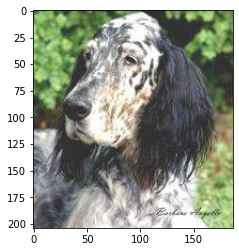

In [5]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

# Keras callbacks

In [6]:
checkpoint = ModelCheckpoint('dog_breed_classifier.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

#https://github.com/keras-team/keras/issues/3358
tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

# Define new top layers and compile model

In [7]:
# base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(rate = .2)(x)
x = BatchNormalization()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
# x = Dropout(rate = .2)(x)
x = BatchNormalization()(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(lr=learning_rate)
# optimizer = RMSprop(lr=learning_rate)

loss = "categorical_crossentropy"
# loss = "kullback_leibler_divergence"

for layer in model.layers:
    layer.trainable = True
# for layer in model.layers[-2:]:
#     layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

model.summary()
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

16711680/16705208 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

# Fit model

In [8]:
%%time

params = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=test_generator, 
                                validation_steps=len(test_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Epoch 1/100
Learning rate:  1e-04
166/166 [==============================] - 320s 2s/step - loss: 3.6078 - accuracy: 0.2320 - val_loss: 1.6543 - val_accuracy: 0.7281

Epoch 00001: val_accuracy improved from -inf to 0.72814, saving model to dog_breed_classifier.h5
Epoch 2/100
Learning rate:  1e-04
166/166 [==============================] - 289s 2s/step - loss: 0.9045 - accuracy: 0.7582 - val_loss: 0.7989 - val_accuracy: 0.7829

Epoch 00002: val_accuracy improved from 0.72814 to 0.78291, saving model to dog_breed_classifier.h5
Epoch 3/100
Learning rate:  1e-04
166/166 [==============================] - 290s 2s/step - loss: 0.5560 - accuracy: 0.8415 - val_loss: 0.6399 - val_accuracy: 0.8131

Epoch 00003: val_accuracy improved from 0.78291 to 0.81311, saving model to dog_breed_classifier.h5
Epoch 4/100
Learning rate:  1e-04
166/166 [==============================] - 290s 2s/step - loss: 0.3990 - accuracy: 0.8911 - val_loss: 0.5916 - val_accuracy: 0.8168

Epoch 00004: val_accuracy improved 

# Training and test loss/accuracy graphs

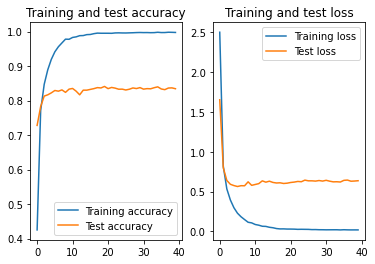

In [9]:
plt.subplot(1, 2, 1)
plt.title('Training and test accuracy')
plt.plot(params.epoch, params.history['accuracy'], label='Training accuracy')
plt.plot(params.epoch, params.history['val_accuracy'], label='Test accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Training and test loss')
plt.plot(params.epoch, params.history['loss'], label='Training loss')
plt.plot(params.epoch, params.history['val_loss'], label='Test loss')
plt.legend()

plt.show()

# Sample prediction

/kaggle/working/cropped/n02091134-whippet/n02091134_10242.jpg
0.869   :   (21, 'n02091134-whippet')
0.07416   :   (19, 'n02090721-Irish_wolfhound')
0.02126   :   (29, 'n02093428-American_Staffordshire_terrier')
0.01073   :   (28, 'n02093256-Staffordshire_bullterrier')
0.009315   :   (95, 'n02109047-Great_Dane')


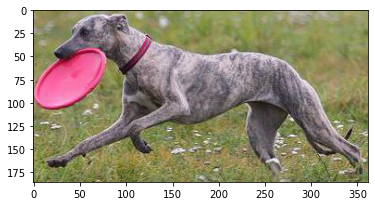

In [10]:
# Randomly test an image from the test set
# model.load_weights('dog_breed_classifier.h5')

imageno=np.random.random_integers(low=0, high=test_generator.samples)

name = test_generator.filepaths[imageno]
print(name)
plt.imshow(mpimg.imread(name))

img = Image.open(test_generator.filepaths[imageno]).resize((targetx, targety))
probabilities = model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])

# Classification report

In [11]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.87      0.90      0.89        30
              n02085782-Japanese_spaniel       0.83      0.92      0.87        37
                   n02085936-Maltese_dog       0.80      0.88      0.84        50
                      n02086079-Pekinese       0.89      0.83      0.86        29
                      n02086240-Shih-Tzu       0.74      0.69      0.72        42
              n02086646-Blenheim_spaniel       0.97      0.89      0.93        37
                      n02086910-papillon       0.95      0.92      0.94        39
                   n02087046-toy_terrier       0.93      0.76      0.84        34
           n02087394-Rhodesian_ridgeback       0.75      0.79      0.77        34
                  n02088094-Afghan_hound       1.00      0.94      0.97        47
                        n02088238-basset       0.79      0.89      0.84    

# Confusion matrix

Confusion Matrix


<AxesSubplot:>

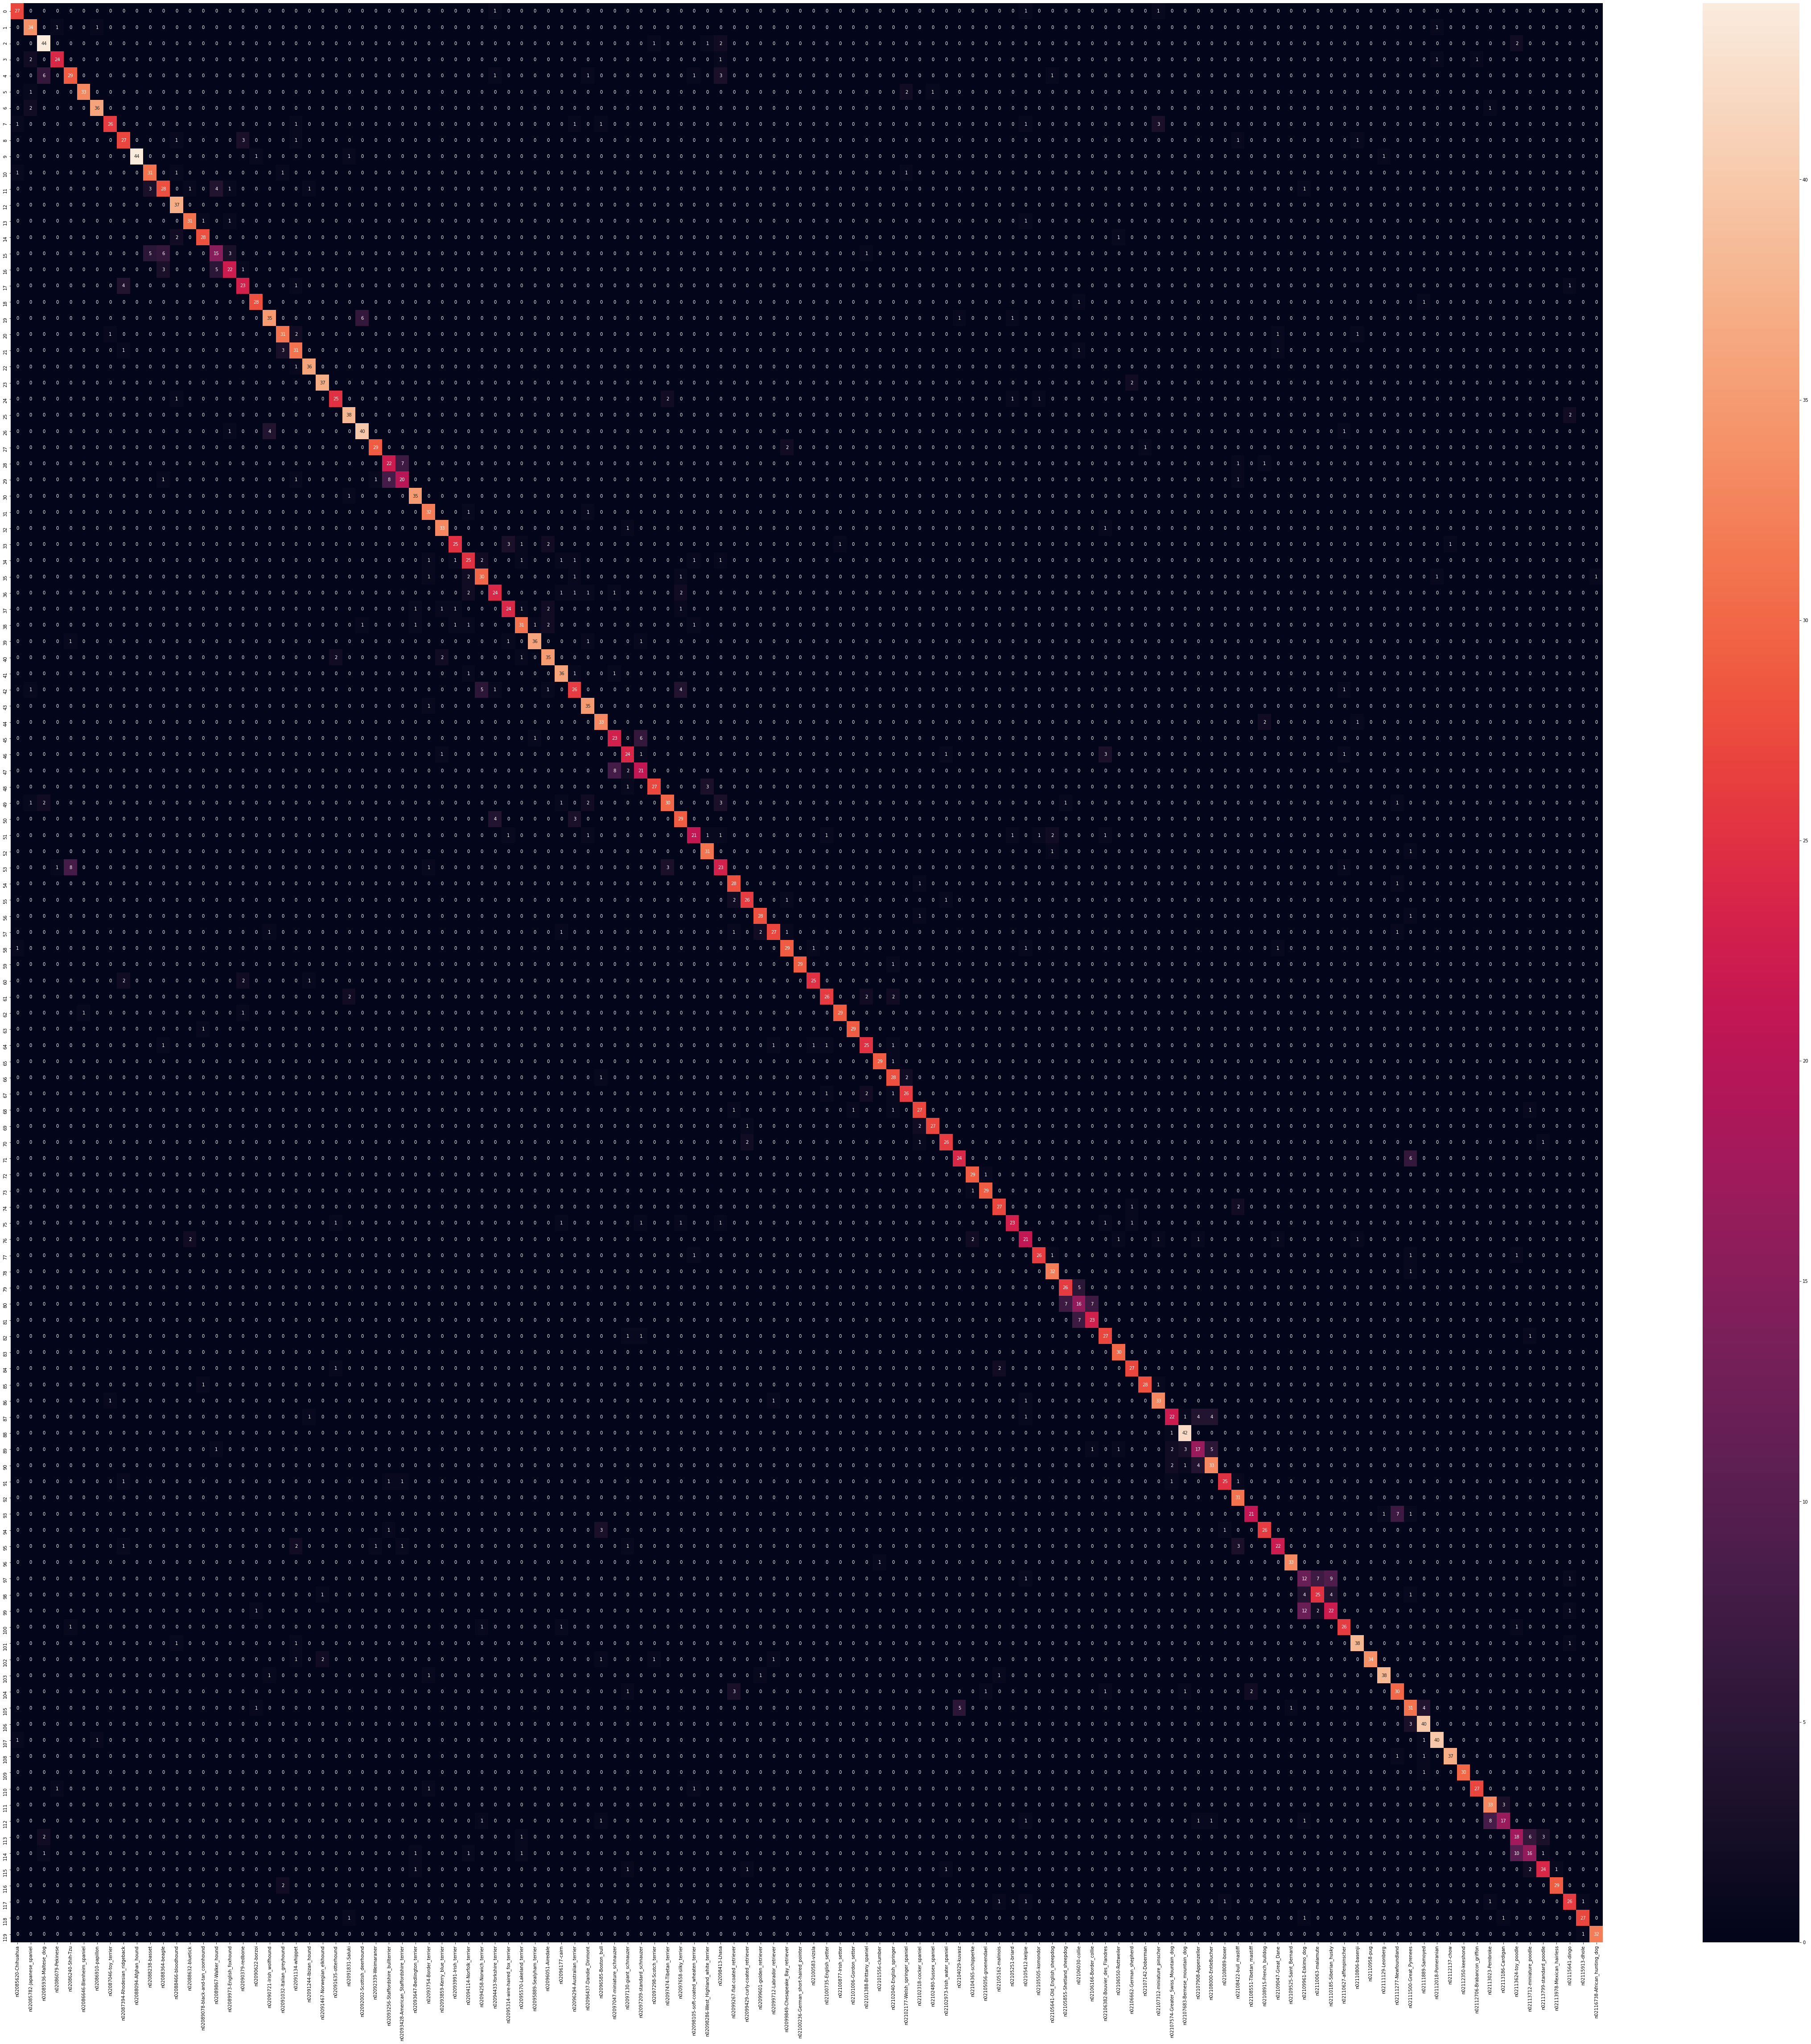

In [12]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y)
df = pd.DataFrame(cm, columns=test_generator.class_indices)
plt.figure(figsize=(80,80))
sn.heatmap(df, annot=True)

In [13]:
shutil.rmtree(cropped_dir)